# Creating a wildtype (WT / PD0), and Parkinson degeneration (PD2) network

In the directory ```network_path``` we have three sub directories ```PD0```, ```PD2-ref``` and ```PD2```. In order to generate the ```PD2``` network, we degenerate the ```PD0``` network by swapping the WT morphologies for the PD2 morphologies. In addition a subset of the synapses in the ```PD2-ref``` network are added to compensate for differences in pruning.

We need to specify a ```connection_override``` file. The difference compared to the standard connection file is that it contains ```recovery``` information, i.e. the fraction of synapses from the ```PD2-ref``` network that should be added to the ```PD2``` network.

The ```rc``` object is a ```ipyparallel``` ```RemoteClient``` object for parallel execution.

If you want to remap external input that was removed to a new position, then use ```remap_removed_input = True```

In [1]:
import os

network_path = os.path.join("networks","PD-example-2k")
#network_path = os.path.join("networks","PD-example-2_ref_0.9")

network_path_pd0 = os.path.join(network_path, "PD0")
network_path_pd2_ref = os.path.join(network_path, "PD2-ref")
network_path_pd2 = os.path.join(network_path, "PD2")

network_size = 2000
input_config = "test-input.json"  # Only background input will be used in this example

snudda_data_base_path = os.path.join("..", "..", "..", "..", "BasalGangliaData", "Parkinson", "20221213")
snudda_data_pd0 = os.path.join(snudda_data_base_path, "PD0")
snudda_data_pd2 = os.path.join(snudda_data_base_path, "PD2")

network_config_pd0 = os.path.join(snudda_data_base_path, "connectivity", "network-config.json")
# network_config_pd2 = os.path.join(snudda_data_base_path, "connectivity", "network-config-PD-synapse-recovery.json")
network_config_pd2 = os.path.join(snudda_data_base_path, "connectivity", "network-config-PD-basic.json")


input_pd0 = os.path.join(network_path_pd0, "input-spikes.hdf5")
input_pd2 = os.path.join(network_path_pd2, "input-spikes.hdf5")

# Do we want to remap removed input?
remap_removed_input = False
remapped_fraction = 0.0

# Do we want to remap removed input? -- if so we need to use network-config-PD-synapse.recovery.json also.
#remap_removed_input = True
#remapped_fraction = 0.9

rc = None

## First generate the WT reference network

In [2]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd0, random_seed=123456, snudda_data=snudda_data_pd0,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd0)

Adding Striatum with 2000 neurons (stay_inside=False)
Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/0/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/0/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/1/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/1/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/2/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/2/me

In [3]:
from snudda import Snudda
snd_pd0 = Snudda(network_path=network_path_pd0)
snd_pd0.create_network()

Placing neurons
Network path: networks/PD-example-2k/PD0
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2k/PD0/network-config.json
Generating 9874 points for networks/PD-example-2k/PD0/mesh/Striatum-cube-mesh-0.00029179512939439816.obj
n_points = 9391, previous close_pairs = 19506
n_points = 8933, previous close_pairs = 15994
n_points = 8499, previous close_pairs = 13287
n_points = 8088, previous close_pairs = 11138
n_points = 7700, previous close_pairs = 9311
n_points = 7336, previous close_pairs = 7862
n_points = 6996, previous close_pairs = 6524
n_points = 6679, previous close_pairs = 5538
n_points = 6387, previous close_pairs = 4640
n_points = 6119, previous close_pairs = 3828
n_points = 5873, previous close_pairs = 3277
n_points = 5650, previous close_pairs = 2808
n_points = 5448, previous close_pairs = 2382
n_points = 5268, previous close_pairs = 2002
n_points = 5111, previous close_pairs = 1662
n_points = 5080, previous clos

In [4]:
snd_pd0.setup_input(input_config=input_config)

Setting up inputs, assuming input.json exists
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2k/PD0/network-config.json
Writing input spikes to networks/PD-example-2k/PD0/input-spikes.hdf5
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2k/PD0/network-config.json
Writing spikes to networks/PD-example-2k/PD0/input-spikes.hdf5
stop_parallel disabled, to keep pool running.

Execution time: 435.2s


## Generate a PD2 reference network

This network will not have the same synapses as the WT, but it is used in order to add "recovery synapses" to compensate for part of the degeneration.

In [5]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd2_ref, random_seed=123456, snudda_data=snudda_data_pd2,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd2)

Adding Striatum with 2000 neurons (stay_inside=False)
Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/0/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/0/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/1/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/1/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/2/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/2/me

In [6]:
from snudda import Snudda
snd_pd2_ref = Snudda(network_path=network_path_pd2_ref)
snd_pd2_ref.create_network()

Placing neurons
Network path: networks/PD-example-2k/PD2-ref
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2k/PD2-ref/network-config.json
Generating 9874 points for networks/PD-example-2k/PD2-ref/mesh/Striatum-cube-mesh-0.00029179512939439816.obj
n_points = 9391, previous close_pairs = 19506
n_points = 8933, previous close_pairs = 15994
n_points = 8499, previous close_pairs = 13287
n_points = 8088, previous close_pairs = 11138
n_points = 7700, previous close_pairs = 9311
n_points = 7336, previous close_pairs = 7862
n_points = 6996, previous close_pairs = 6524
n_points = 6679, previous close_pairs = 5538
n_points = 6387, previous close_pairs = 4640
n_points = 6119, previous close_pairs = 3828
n_points = 5873, previous close_pairs = 3277
n_points = 5650, previous close_pairs = 2808
n_points = 5448, previous close_pairs = 2382
n_points = 5268, previous close_pairs = 2002
n_points = 5111, previous close_pairs = 1662
n_points = 5080, p

In [7]:
snd_pd2_ref.setup_input(input_config=input_config)

Setting up inputs, assuming input.json exists
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2k/PD2-ref/network-config.json
Writing input spikes to networks/PD-example-2k/PD2-ref/input-spikes.hdf5
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2k/PD2-ref/network-config.json
Writing spikes to networks/PD-example-2k/PD2-ref/input-spikes.hdf5
stop_parallel disabled, to keep pool running.

Execution time: 325.7s


## Degenerating the PD0 network to get PD2 network

In [8]:
network_file_pd0 = os.path.join(network_path_pd0, "network-synapses.hdf5")
network_file_pd2_ref = os.path.join(network_path_pd2_ref, "network-synapses.hdf5")
network_file_pd2 = os.path.join(network_path_pd2, "network-synapses.hdf5")

from snudda.utils.swap_to_degenerated_morphologies_extended import SwapToDegeneratedMorphologiesExtended
swap = SwapToDegeneratedMorphologiesExtended(original_network_file=network_file_pd0,
                                             updated_network_file=network_file_pd2_ref,
                                             output_network_file=network_file_pd2,
                                             original_snudda_data_dir=snudda_data_pd0,
                                             updated_snudda_data_dir=snudda_data_pd2,
                                             original_input_file=input_pd0,
                                             output_input_file=input_pd2)
swap.write_new_network_file()
swap.write_new_input_file(remap_removed_input=remap_removed_input, remapped_fraction=remapped_fraction)
swap.close()

Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/fs/2/MTC180800A-IDB-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/fs/0/BE104E-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/fs/3/MTC251001A-IDB-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/chin/str-chin-e170614_cell6-m17JUL301751_170614_no6_MD_cell_1_x63-v20190710/optim_chin_morph_renamed2019-11-08.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/lts/0/lts_morp_9862_centered_no_axon_resampled-var0.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/fs/1/DR-rat-Mar-13-08-1-536-R-cor-rep-res3-61.swc-ca

/home/hjorth/HBP/Snudda/snudda/utils/swap_to_degenerated_morphologies.py:295: RuntimeWarning: invalid value encountered in cast
  edited_synapses[:, 10] = new_sec_x * 1000


Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/0/BE104E-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/3/MTC251001A-IDB-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/1/DR-rat-Mar-13-08-1-536-R-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/chin/str-chin-e170614_cell6-m17JUL301751_170614_no6_MD_cell_1_x63-v20190710/optim_chin_morph_renamed2019-11-08.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/lts/3/lts_morp_9862_centered_no_axon_resampled-var3.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/lts/0/lts_morp_9862_centered_no_axon_resam

## Plotting of a degenerated neuron

In [9]:
# This is so we get the most central dSPN in the network
from snudda import SnuddaLoad
sl = SnuddaLoad(network_path_pd0)
neuron_id = list(sl.get_centre_neurons_iterator(neuron_type="dSPN", n_neurons=1))[0][0]

In [10]:
# neuron_id = 55
neuron_id

615

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2k/PD0/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2k/PD0/network-config.json
Plotting 200 external synapses
Plotting 200 external synapses


/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:118: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=coords[:, 0], ys=coords[:, 1], zs=coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:125: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=syn_coords[:, 0], ys=syn_coords[:, 1], zs=syn_coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.p

Figure written: networks/PD-example-2k/PD0/figures/input-to-615-dSPN_15-and-internal-synapses.png


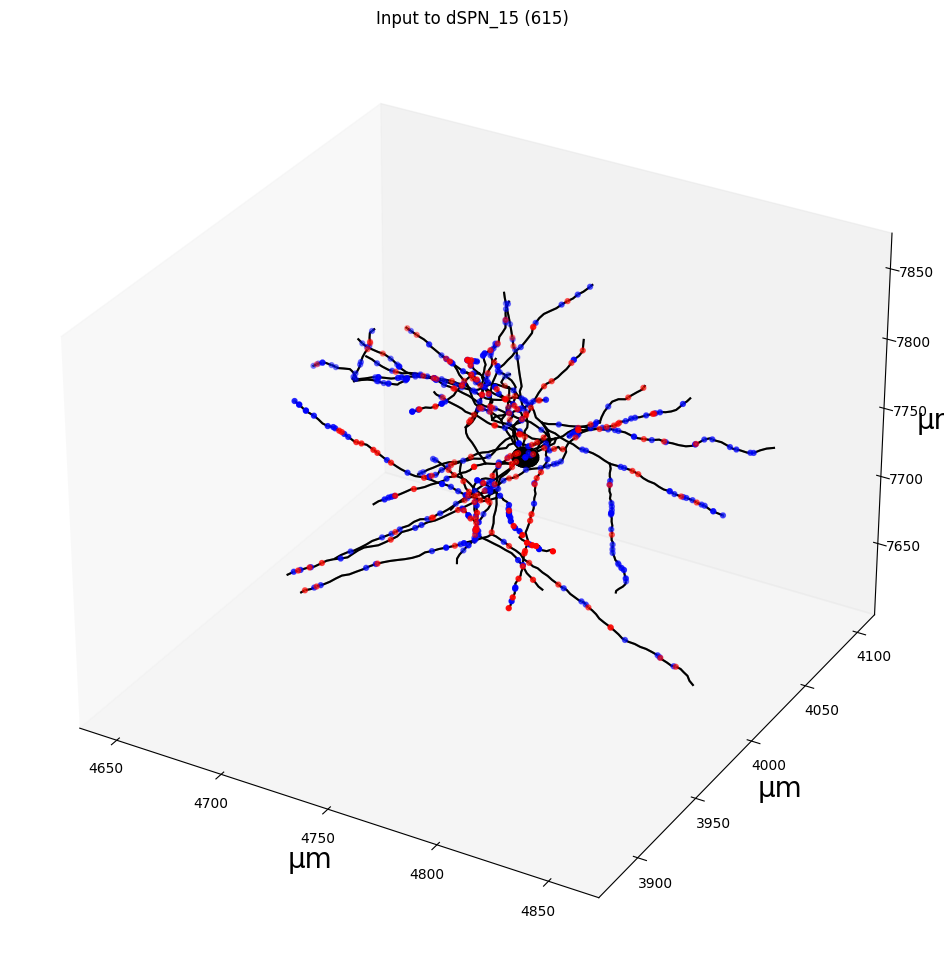

In [11]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

# Note here original and degenerate path were the same, so we are plotting the full neuron and its synapses.
pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd0)

pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)
#internal synapses are blue
#external synapses are red

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2k/PD0/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2k/PD2/network-synapses.hdf5
Plotting 200 external synapses
Plotting 60 external synapses


/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:118: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=coords[:, 0], ys=coords[:, 1], zs=coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:125: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=syn_coords[:, 0], ys=syn_coords[:, 1], zs=syn_coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.p

Figure written: networks/PD-example-2k/PD2/figures/input-to-615-dSPN_15-and-internal-synapses.png


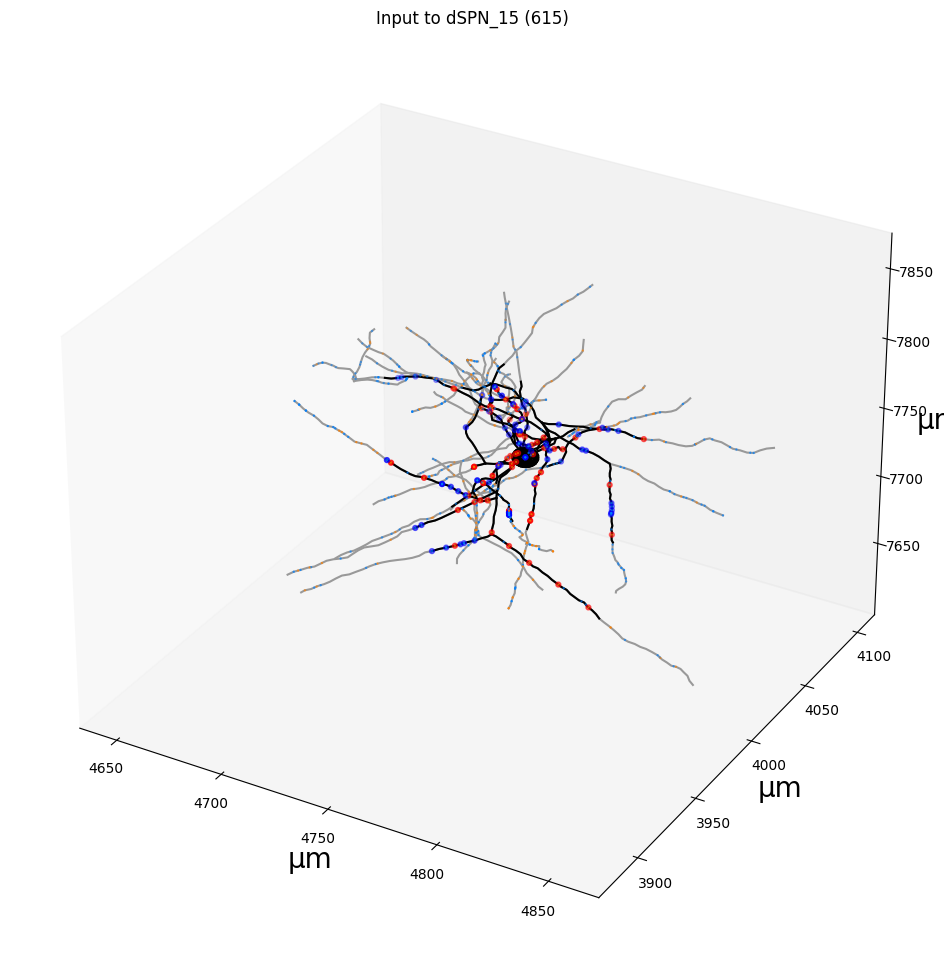

In [12]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2)

pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2k/PD0/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2k/PD2-ref/network-config.json
Plotting 200 external synapses
Plotting 200 external synapses


/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:118: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=coords[:, 0], ys=coords[:, 1], zs=coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:125: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=syn_coords[:, 0], ys=syn_coords[:, 1], zs=syn_coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.p

Figure written: networks/PD-example-2k/PD2-ref/figures/input-to-615-dSPN_15-and-internal-synapses.png


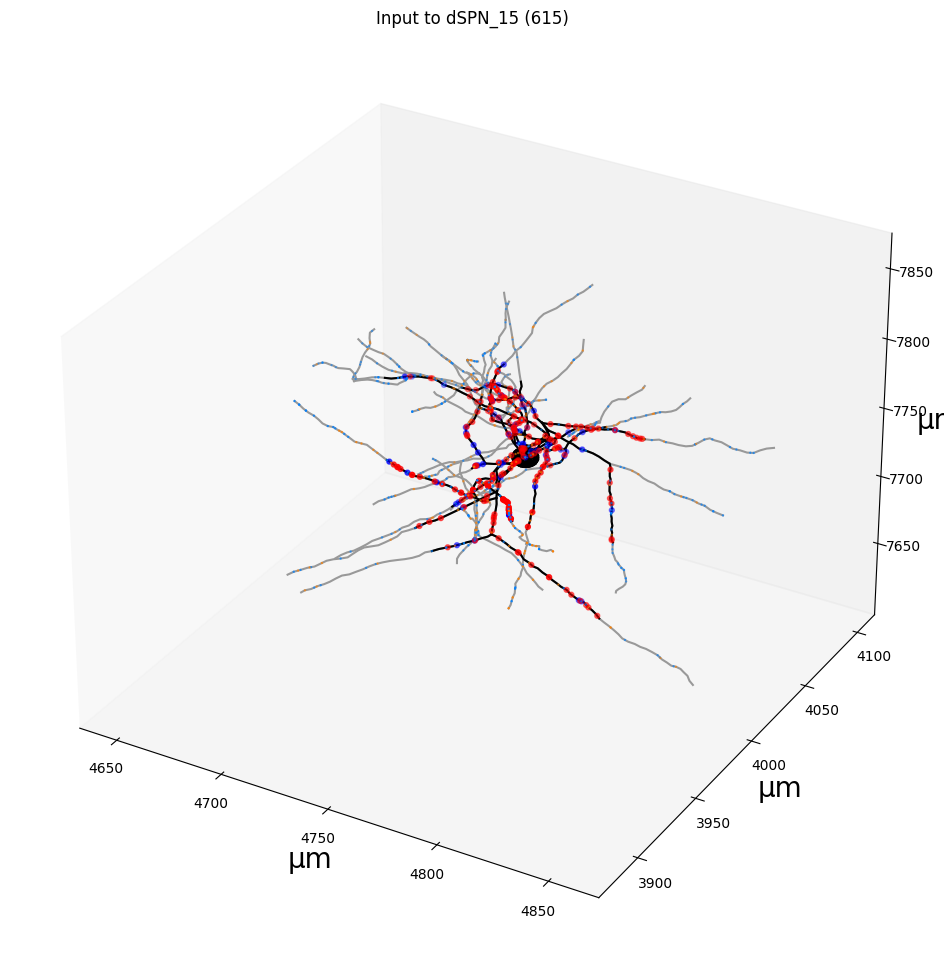

In [13]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2_ref)
#neuron_id = 55
pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)

In [14]:
from snudda.analyse.analyse_input import AnalyseInput

pd0_input_info = AnalyseInput(input_file=input_pd0, network_path=network_path_pd0)
pd2_input_info = AnalyseInput(input_file=input_pd2, network_path=network_path_pd2)

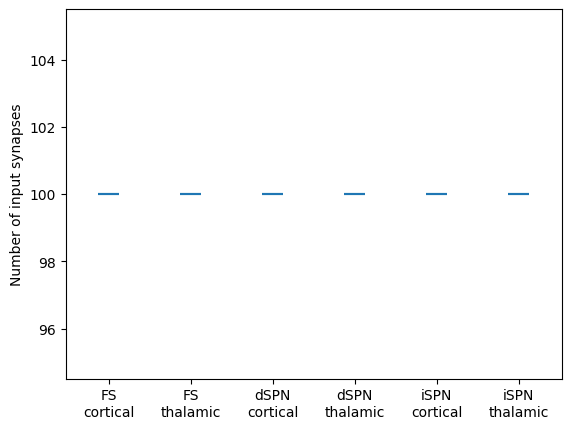

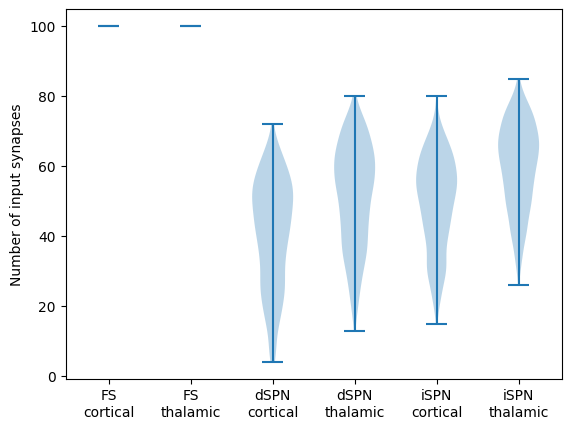

In [15]:
pd0_input_info.plot_input_count("PD0-input_example.png")
pd2_input_info.plot_input_count("PD2-input_example.png")

In [16]:
cmd_str1 = f"snudda_load {network_path_pd0}/network-synapses.hdf5 --countSyn"
cmd_str2 = f"snudda_load {network_path_pd2}/network-synapses.hdf5 --countSyn"
cmd_str3 = f"snudda_load {network_path_pd2_ref}/network-synapses.hdf5 --countSyn"

print("WT")
os.system(cmd_str1)
print("\nPD2")
os.system(cmd_str2)
print("\nPD2 degenerated")
os.system(cmd_str3)

WT
Loading networks/PD-example-2k/PD0/network-synapses.hdf5
Loading config data from HDF5
Loading 1996 neurons with 696768 synapses and 150 gap junctions
Load done. 0.1
ChIN -> LTS: 268 synapses
ChIN -> dSPN: 4472 synapses
ChIN -> iSPN: 5170 synapses
FS -> FS: 281 synapses
FS -> LTS: 26 synapses
FS -> dSPN: 24388 synapses
FS -> iSPN: 15105 synapses
LTS -> ChIN: 207 synapses
LTS -> dSPN: 1080 synapses
LTS -> iSPN: 802 synapses
dSPN -> ChIN: 185 synapses
dSPN -> dSPN: 143459 synapses
dSPN -> iSPN: 35217 synapses
iSPN -> ChIN: 161 synapses
iSPN -> dSPN: 155056 synapses
iSPN -> iSPN: 310891 synapses

PD2
Loading networks/PD-example-2k/PD2/network-synapses.hdf5
Loading config data from HDF5
Loading 1996 neurons with 231446 synapses and 150 gap junctions
Load done. 0.1
ChIN -> LTS: 268 synapses
ChIN -> dSPN: 763 synapses
ChIN -> iSPN: 1599 synapses
FS -> FS: 384 synapses
FS -> LTS: 32 synapses
FS -> dSPN: 20169 synapses
FS -> iSPN: 14010 synapses
LTS -> ChIN: 207 synapses
LTS -> dSPN: 326 sy

0

In [17]:
cmd_str1 = f"snudda_load {network_path_pd0}/network-synapses.hdf5 --listPre {neuron_id}"
cmd_str2 = f"snudda_load {network_path_pd2}/network-synapses.hdf5 --listPre {neuron_id}"
cmd_str3 = f"snudda_load {network_path_pd2_ref}/network-synapses.hdf5 --listPre {neuron_id}"

print("WT")
os.system(cmd_str1)
print("\nPD2")
os.system(cmd_str2)
print("\nPD2 degenerated")
os.system(cmd_str3)

WT
Loading networks/PD-example-2k/PD0/network-synapses.hdf5
Loading config data from HDF5
Loading 1996 neurons with 696768 synapses and 150 gap junctions
Load done. 0.1
List neurons pre-synaptic to neuron_id = 615 (dSPN_15)
The neuron receives 378 synapses
60 : FS_2 (6 synapses)
66 : dSPN_12 (3 synapses)
95 : iSPN_35 (1 synapses)
102 : dSPN_22 (3 synapses)
105 : dSPN_23 (2 synapses)
114 : iSPN_15 (3 synapses)
143 : dSPN_19 (4 synapses)
166 : dSPN_33 (3 synapses)
208 : iSPN_31 (4 synapses)
225 : iSPN_32 (3 synapses)
229 : dSPN_13 (2 synapses)
238 : iSPN_15 (3 synapses)
241 : iSPN_31 (3 synapses)
243 : FS_0 (3 synapses)
244 : dSPN_11 (4 synapses)
245 : dSPN_11 (3 synapses)
250 : dSPN_26 (2 synapses)
277 : iSPN_8 (3 synapses)
290 : dSPN_14 (3 synapses)
314 : iSPN_14 (3 synapses)
317 : iSPN_25 (2 synapses)
326 : dSPN_9 (3 synapses)
335 : iSPN_14 (3 synapses)
342 : dSPN_9 (5 synapses)
344 : dSPN_15 (4 synapses)
349 : dSPN_29 (4 synapses)
358 : FS_3 (3 synapses)
361 : dSPN_11 (2 synapses)
44

0

Added: 13, removed: 274, kept: 53


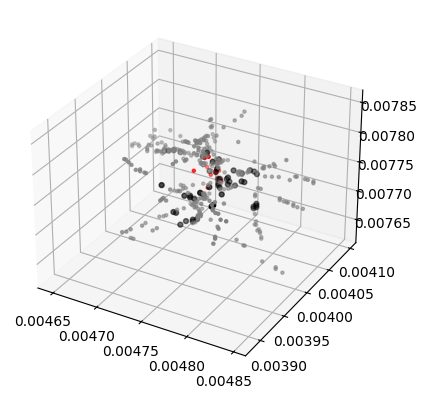

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

In [18]:
from snudda.plotting.plot_degeneration_and_growth import PlotDegenerationAndGrowth
pdg = PlotDegenerationAndGrowth(original_network_path=network_path_pd0, 
                                degenerated_network_path=network_path_pd2, 
                                neuron_id=neuron_id)
pdg.plot_synapses()

Added: 51, removed: 312, kept: 15


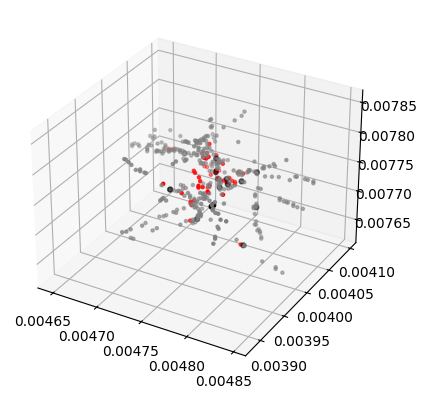

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

In [19]:
from snudda.plotting.plot_degeneration_and_growth import PlotDegenerationAndGrowth
pdg = PlotDegenerationAndGrowth(original_network_path=network_path_pd0, 
                                degenerated_network_path=network_path_pd2_ref, 
                                neuron_id=neuron_id)
pdg.plot_synapses()

In [20]:
from snudda.analyse.analyse import SnuddaAnalyse


network_file_pd0 = os.path.join(network_path_pd0, "network-synapses.hdf5")
network_file_pd2 = os.path.join(network_path_pd2, "network-synapses.hdf5")
network_file_pd2_ref = os.path.join(network_path_pd2_ref, "network-synapses.hdf5")

dist3D = False
y_max_H = None

sa_pd0 = SnuddaAnalyse(network_file_pd0)
sa_pd2 = SnuddaAnalyse(network_file_pd2)
sa_pd2_ref = SnuddaAnalyse(network_file_pd2_ref)    

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Number of neurons: 1996
Synapse row 0 - 0.0 % time: 0.04507051799737383 seconds
Created connection matrix 0.8288781139999628 seconds
GJ row : 0 - 0.0 %  time : 0.0018527909996919334 seconds
Created gap junction connection matrix 0.0022579159995075315 seconds
Creating population dictionary
Done.
Taking corner neurons: Keeping 1996/1996
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 696768, at 0
Created distance histogram (optimised) in 0.8270151549950242 seconds
Saving cache to networks/PD-example-2k/PD0/network-synapses.hdf5-cache
Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Number of neurons: 1996
Synapse row 0 - 0.0 % time: 0.024513195996405557 seconds
Created connection matrix 0.29931092899641953 seconds
GJ row : 0 - 0.0 %  time : 0.0007791250027366914 seconds
Created gap junction connection matrix 0.0011594160023378208 s

Plotting connection probability dSPN to iSPN (synapses)
Centering in None : Keeping 967/967
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [935089.]
P(d<5e-05) = 0.058229722882644115
P(d<0.0001) = 0.04191826098010551
Plotting connection probability dSPN to iSPN (synapses)
Centering in None : Keeping 967/967
Counting connections
Requested: 10000000.0 calculated [935089.]


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


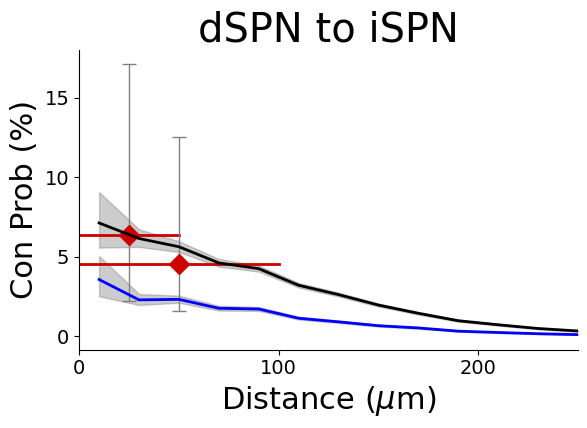

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-dSPN-to-iSPN-synapses-3D-dist.png


({},
 'networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-dSPN-to-iSPN-synapses-3D-dist.png')

In [21]:
ax = sa_pd0.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("dSPN", "iSPN", dist_3d=True, ax=ax, colour="blue")

Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 13709 connections


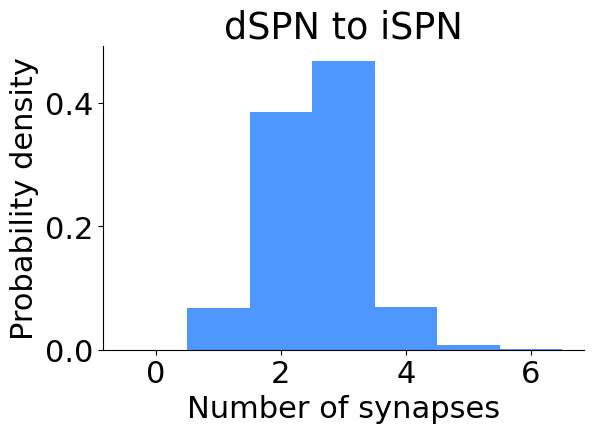

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-dSPN-to-iSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 4907 connections


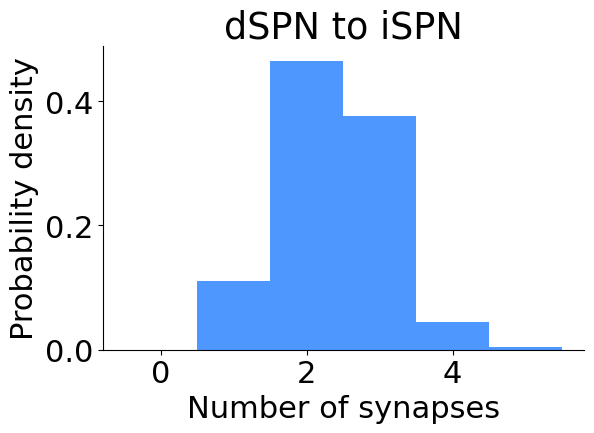

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-dSPN-to-iSPN-per-cell.png


In [22]:
sa_pd0.plot_num_synapses_per_pair("dSPN", "iSPN")
sa_pd2.plot_num_synapses_per_pair("dSPN", "iSPN")

Plotting connection probability dSPN to dSPN (synapses)
Centering in None : Keeping 967/967
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [934122.]
P(d<5e-05) = 0.23927738927738929
P(d<0.0001) = 0.16362852724184265
Plotting connection probability dSPN to dSPN (synapses)
Centering in None : Keeping 967/967
Counting connections
Requested: 10000000.0 calculated [934122.]
P(d<5e-05) = 0.071989121989122


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


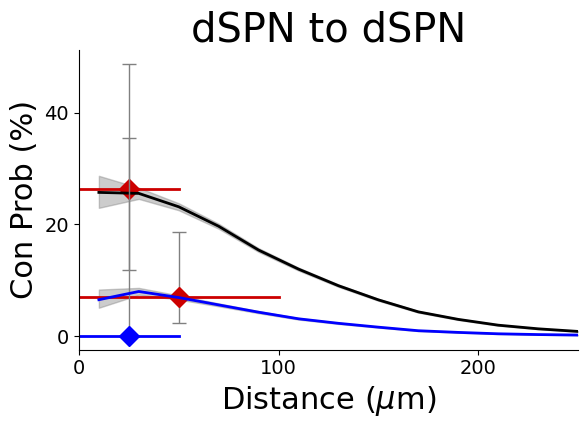

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-dSPN-to-dSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 48077 connections


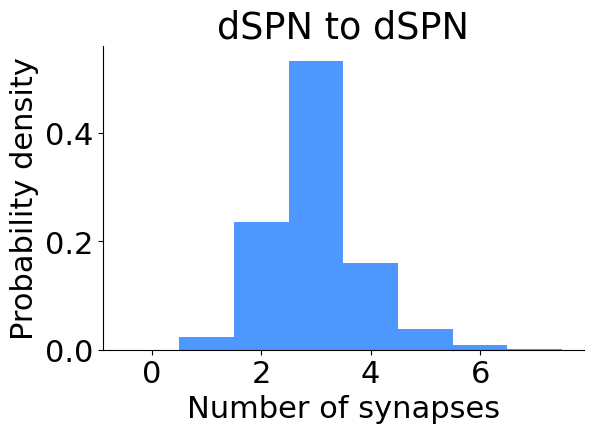

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-dSPN-to-dSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 12428 connections


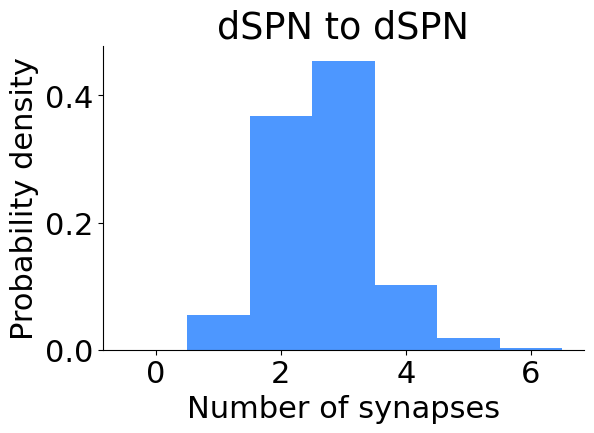

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-dSPN-to-dSPN-per-cell.png


In [23]:
ax = sa_pd0.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("dSPN", "dSPN", dist_3d=True, ax=ax, colour="blue", exp_colour="blue", exp_data_detailed=[(0, 7)], exp_max_dist=[50e-6])

sa_pd0.plot_num_synapses_per_pair("dSPN", "dSPN")
sa_pd2.plot_num_synapses_per_pair("dSPN", "dSPN")

Plotting connection probability iSPN to iSPN (synapses)
Centering in None : Keeping 967/967
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [934122.]
P(d<5e-05) = 0.3430127752958696
P(d<0.0001) = 0.26310198753471464
Plotting connection probability iSPN to iSPN (synapses)
Centering in None : Keeping 967/967
Counting connections
Requested: 10000000.0 calculated [934122.]
P(d<5e-05) = 0.15518457559369855


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


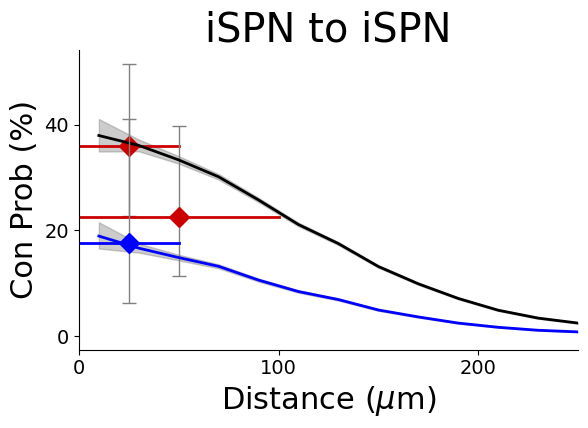

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-iSPN-to-iSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 90049 connections


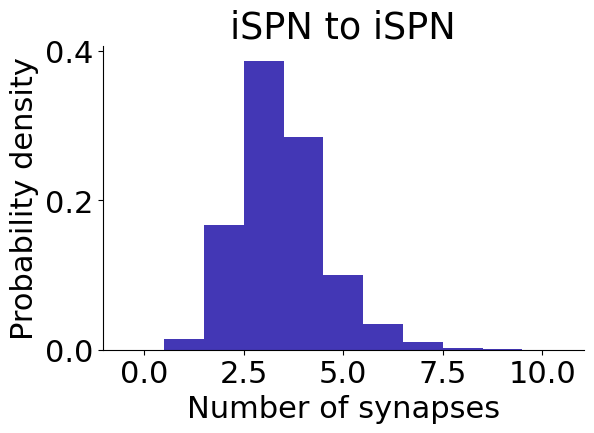

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-iSPN-to-iSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 35165 connections


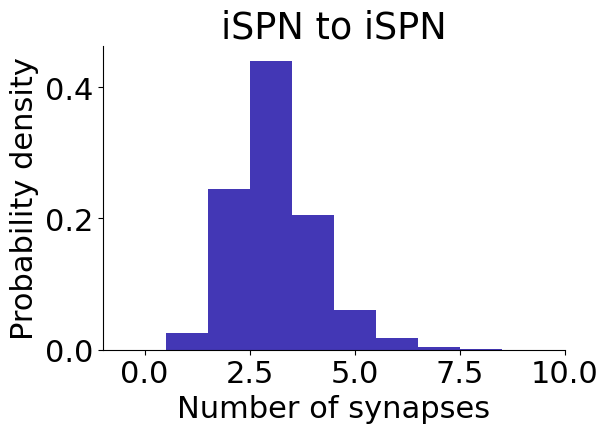

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-iSPN-to-iSPN-per-cell.png


In [24]:
ax = sa_pd0.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)], return_ax=True, show_plot=False, save_figure=False)
# PD connectivity from Taverna et al 2008
sa_pd2.plot_connection_probability("iSPN", "iSPN", dist_3d=True, ax=ax, colour="blue", exp_colour="blue", exp_data_detailed=[(3,17)], exp_max_dist=[50e-6])

sa_pd0.plot_num_synapses_per_pair("iSPN", "iSPN")
sa_pd2.plot_num_synapses_per_pair("iSPN", "iSPN")

Plotting connection probability iSPN to dSPN (synapses)
Centering in None : Keeping 967/967
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [935089.]
P(d<5e-05) = 0.25821413259539305
P(d<0.0001) = 0.17333629949787072
Plotting connection probability iSPN to dSPN (synapses)
Centering in None : Keeping 967/967
Counting connections
Requested: 10000000.0 calculated [935089.]
P(d<5e-05) = 0.09159293759987527


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


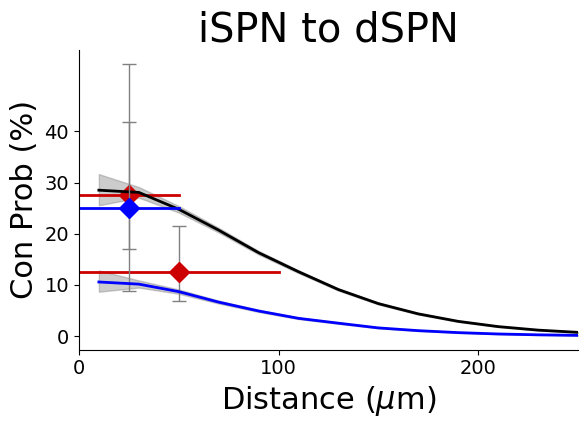

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-iSPN-to-dSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 48844 connections


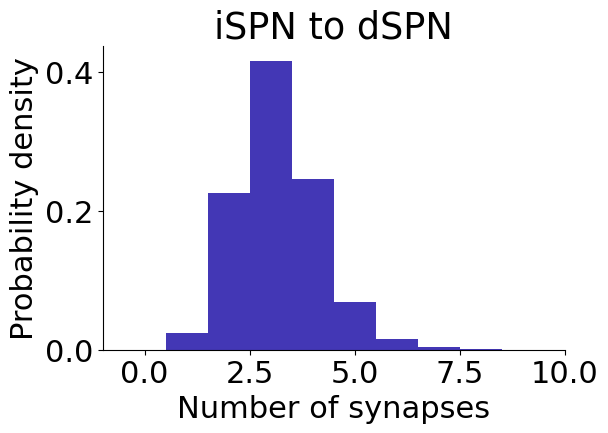

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-iSPN-to-dSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 13921 connections


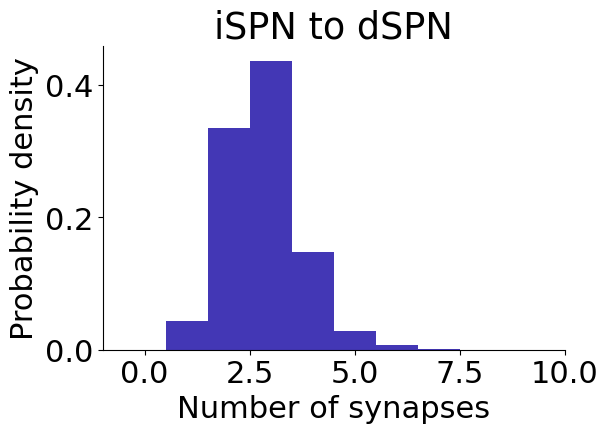

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-iSPN-to-dSPN-per-cell.png


In [25]:
ax = sa_pd0.plot_connection_probability("iSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(13, 47), (10, 80)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("iSPN", "dSPN", dist_3d=True, ax=ax, colour="blue", exp_colour="blue", exp_max_dist=[50e-6], exp_data_detailed=[(3, 12)])

sa_pd0.plot_num_synapses_per_pair("iSPN", "dSPN")
sa_pd2.plot_num_synapses_per_pair("iSPN", "dSPN")

Plotting connection probability FS to FS (synapses)
Centering in None : Keeping 26/26
Counting connections
Requested: 10000000.0 calculated [650.]
P(d<0.00025) = 0.1571969696969697
Plotting connection probability FS to FS (synapses)
Centering in None : Keeping 26/26
Counting connections
Requested: 10000000.0 calculated [650.]


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)
/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


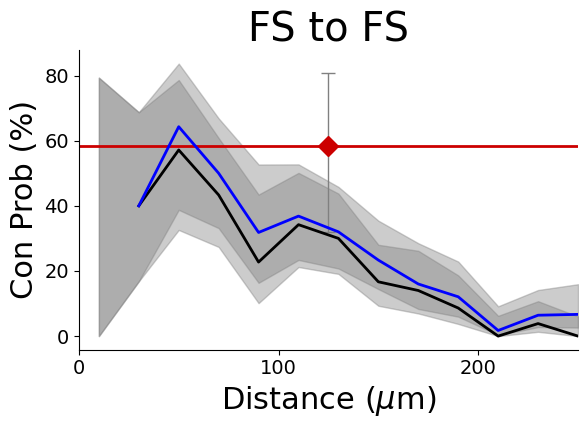

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-FS-to-FS-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 26/26
Calculating max synapses
Calculating mean synapses
Plotting 84 connections


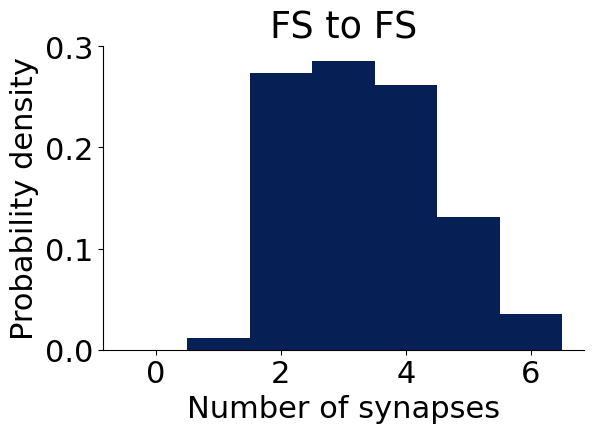

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-FS-to-FS-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 26/26
Calculating max synapses
Calculating mean synapses
Plotting 106 connections


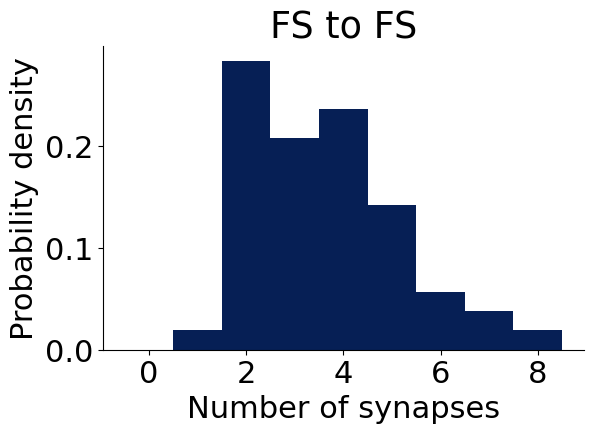

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-FS-to-FS-per-cell.png


In [26]:
ax = sa_pd0.plot_connection_probability("FS", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(7, 12)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("FS", "FS", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("FS", "FS")
sa_pd2.plot_num_synapses_per_pair("FS", "FS")

Plotting connection probability FS to iSPN (synapses)
Centering in None : Keeping 967/967
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [25142.]
P(d<0.0001) = 0.48510219157842893
P(d<0.00015) = 0.3677985501716902
P(d<0.00025) = 0.188703205160766
Plotting connection probability FS to iSPN (synapses)
Centering in None : Keeping 967/967
Counting connections
Requested: 10000000.0 calculated [25142.]


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


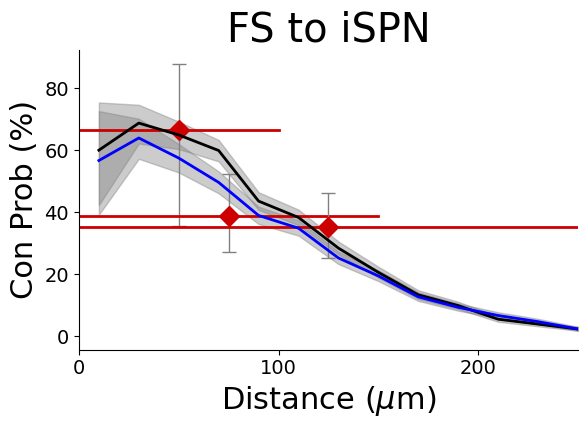

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-FS-to-iSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 3777 connections


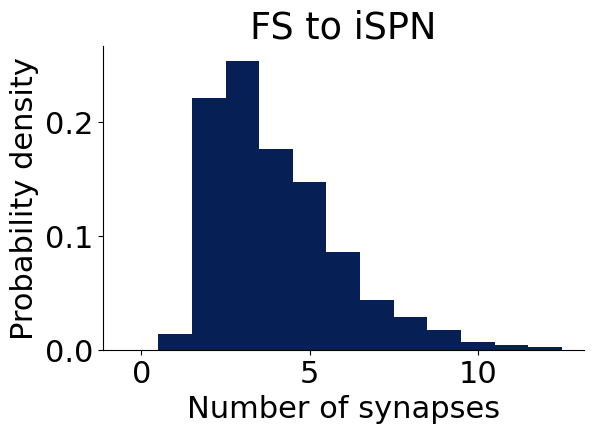

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-FS-to-iSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 3488 connections


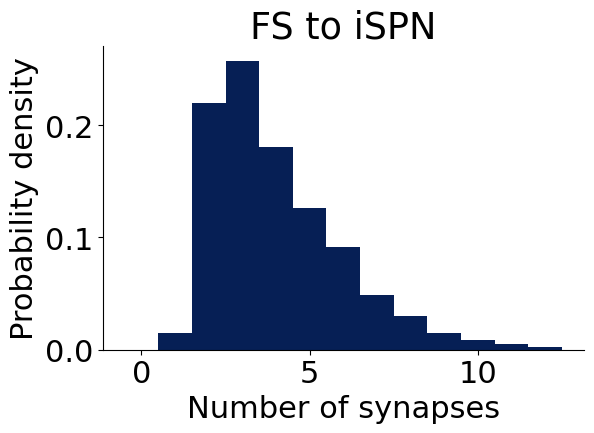

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-FS-to-iSPN-per-cell.png


In [27]:
ax = sa_pd0.plot_connection_probability("FS", "iSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(6, 9), (21, 54), (27,77)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("FS", "iSPN", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("FS", "iSPN")
sa_pd2.plot_num_synapses_per_pair("FS", "iSPN")

Plotting connection probability FS to dSPN (synapses)
Centering in None : Keeping 967/967
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [25142.]
P(d<0.0001) = 0.6496368038740921
P(d<0.00015) = 0.505005005005005
P(d<0.00025) = 0.2799100526396484
Plotting connection probability FS to dSPN (synapses)
Centering in None : Keeping 967/967
Counting connections
Requested: 10000000.0 calculated [25142.]


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


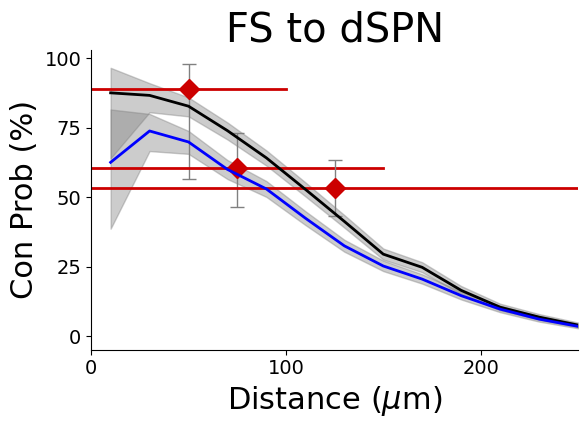

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-FS-to-dSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 5616 connections


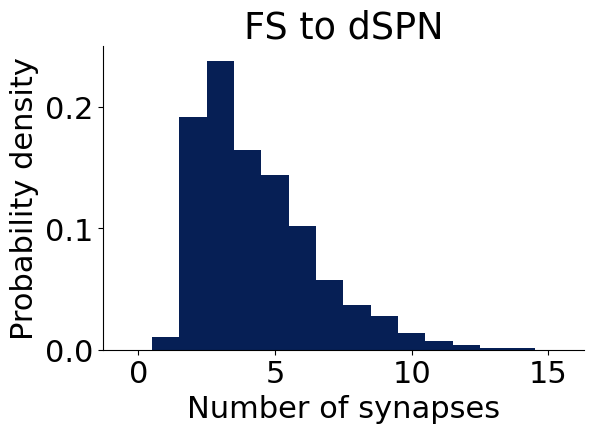

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-FS-to-dSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 967/967
Calculating max synapses
Calculating mean synapses
Plotting 4674 connections


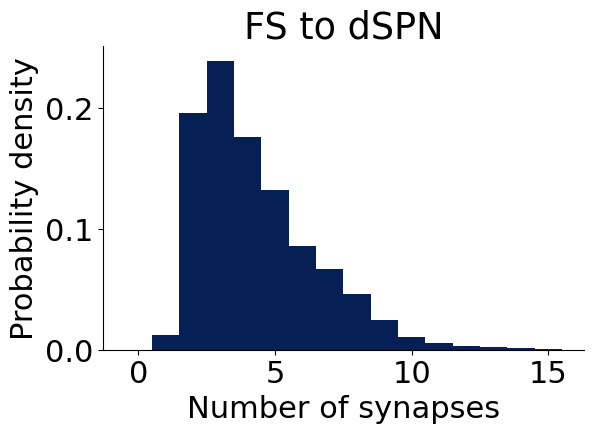

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-FS-to-dSPN-per-cell.png


In [28]:
ax = sa_pd0.plot_connection_probability("FS", "dSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(8, 9), (29, 48), (48,90)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("FS", "dSPN", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("FS", "dSPN")
sa_pd2.plot_num_synapses_per_pair("FS", "dSPN")